New sequence shapes:
X_train shape: (8458, 7, 1)
y_train shape: (8458, 7)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_60 (LSTM)      │ (None, 7, 128)    │     66,560 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_61 (LSTM)      │ [(None, 128),     │    131,584 │ lstm_60[0][0]     │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 128)    │          0 │ lstm_61[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_62 (LSTM)      │ (None, 7, 128)    │    131,584 │ repeat_vector_20… │
│                     │                   │            │ lstm_61[0][1],    │
│                     │                   │            │ lstm_61[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_63 (LSTM)      │ (None, 7, 128)    │    131,584 │ lstm_62[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 7, 1)      │        129 │ lstm_63[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7304 - val_loss: 0.6748
Epoch 2/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.6089 - val_loss: 0.6167
Epoch 3/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5781 - val_loss: 0.5838
Epoch 4/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5435 - val_loss: 0.5730
Epoch 5/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5408 - val_loss: 0.5602
Epoch 6/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.5734 - val_loss: 0.5784
Epoch 7/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5551 - val_loss: 0.5679
Epoch 8/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.5289 - val_loss: 0.5645
Epoch 9/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5667 - val_loss: 0.5576
Epoch 10/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5335 - val_loss: 0.5863
Epoch 11/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.5384 - val_loss: 0.5709
Epoch 12/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

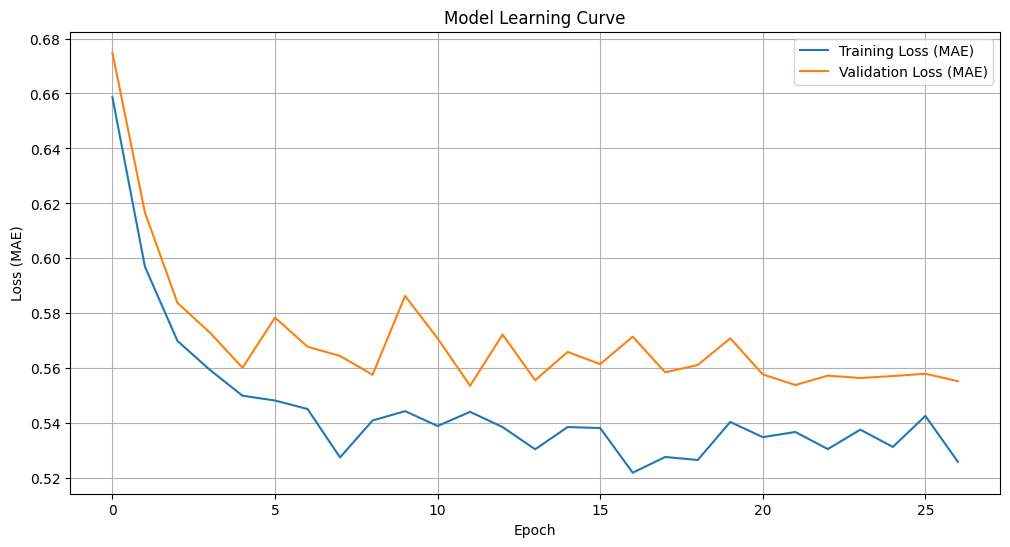

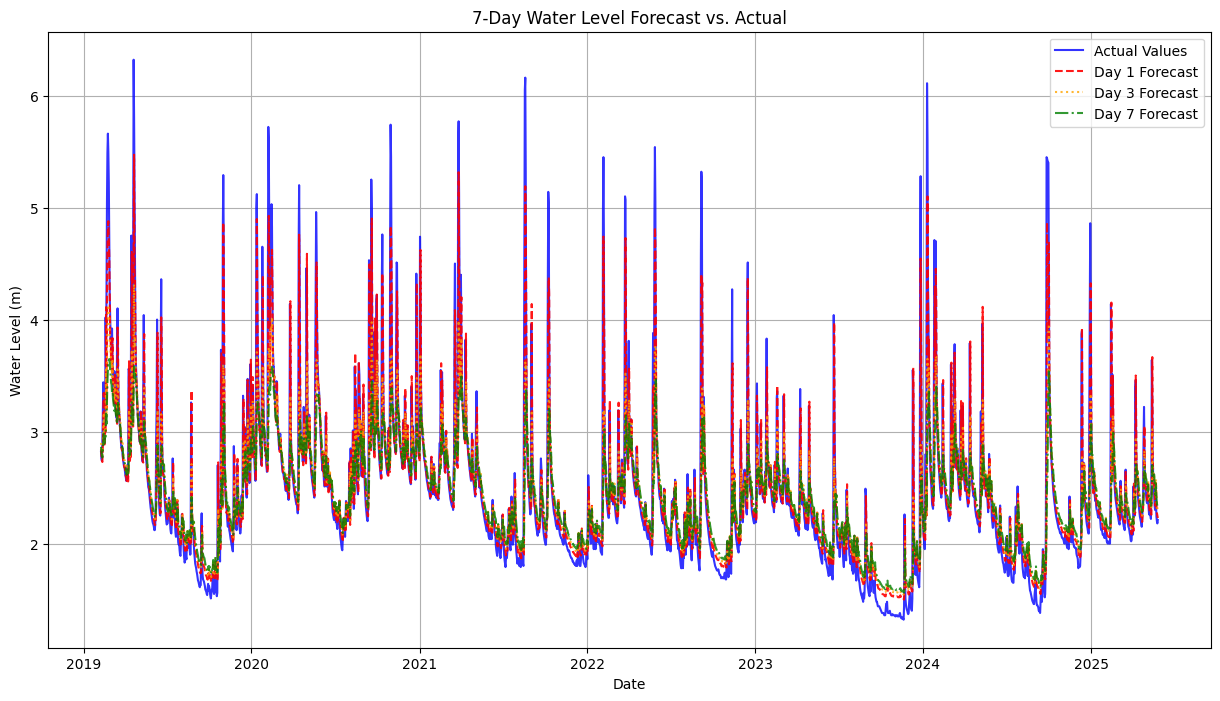

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Load and Prepare Data (No changes needed here)
df = pd.read_csv('dataset.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df_univariate = df[['stage_m']].copy()
df_univariate.interpolate(method='linear', inplace=True)

# 2. Split Data with a Gap (Same as before)
split_date_train_end = '2019-01-01'
split_date_val_start = '2019-02-01'
train_data = df_univariate.loc[df_univariate.index < split_date_train_end]
val_data = df_univariate.loc[df_univariate.index >= split_date_val_start]

# 3. Scale Data (Same as before)
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

# 4. Create Sequences ## TISZA-RIVER STUDY REFACTOR (V2) ##
N_PAST = 7   # Use 15 days of history
N_FUTURE = 7  # Predict 7 days into the future

def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, 0])
        y.append(data[i:i + n_future, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_data, N_PAST, N_FUTURE)
X_val, y_val = create_sequences(scaled_val_data, N_PAST, N_FUTURE)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print(f"New sequence shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# 5. Build Stacked LSTM Encoder-Decoder ## TISZA-RIVER STUDY REFACTOR (V2) ##
n_features = X_train.shape[2]
UNITS = 128
DROPOUT_RATE = 0.15

# --- Encoder ---
inputs = Input(shape=(N_PAST, n_features))
# Layer 1
encoder_l1 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(inputs)
# Layer 2
encoder_l2, state_h, state_c = LSTM(UNITS, return_sequences=False, dropout=DROPOUT_RATE, return_state=True)(encoder_l1)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_inputs = RepeatVector(N_FUTURE)(encoder_l2)
# Layer 1
decoder_l1 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(decoder_inputs, initial_state=encoder_states)
# Layer 2
decoder_l2 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(decoder_l1)
# Output Layer
output = TimeDistributed(Dense(1))(decoder_l2)

model = Model(inputs=inputs, outputs=output)

# 6. Compile Model with Paper's Specs ## TISZA-RIVER STUDY REFACTOR (V2) ##
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error') # Using MAE as the loss function
model.summary()

# 7. Train the Model with Paper's Specs ## TISZA-RIVER STUDY REFACTOR (V2) ##
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_tisza_replication_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train,
    y_train,
    epochs=150, # Set high, EarlyStopping will find the best
    batch_size=128, # Using paper's batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 8. Evaluation and Visualization (No changes needed in this section's logic)
best_model = tf.keras.models.load_model('best_tisza_replication_model.keras')
predictions_scaled = best_model.predict(X_val).squeeze()
predictions_original = scaler.inverse_transform(predictions_scaled)
y_true_original = scaler.inverse_transform(y_val)

print("\n--- Model Performance on Validation Set ---")
for i in range(N_FUTURE):
    day = i + 1
    mae = mean_absolute_error(y_true_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(y_true_original[:, i], predictions_original[:, i]))
    r2 = r2_score(y_true_original[:, i], predictions_original[:, i])
    print(f"Day {day} Ahead -> MAE: {mae:.4f} m, RMSE: {rmse:.4f} m, R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (MAE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.show()

val_dates = val_data.index[N_PAST:len(y_true_original) + N_PAST]
plt.figure(figsize=(15, 8))
plt.plot(val_dates, y_true_original[:, 0], label='Actual Values', color='blue', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 0], label='Day 1 Forecast', color='red', linestyle='--', alpha=0.9)
plt.plot(val_dates, predictions_original[:, 2], label='Day 3 Forecast', color='orange', linestyle=':', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 6], label='Day 7 Forecast', color='green', linestyle='-.', alpha=0.8)
plt.title('7-Day Water Level Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()